In [1]:
import GPy
import itertools  # Import the itertools module
import numpy as np
import math
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize,fmin_l_bfgs_b
from scipy.spatial import ConvexHull, Voronoi
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde

from skopt import BayesSearchCV
from skopt.space import Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Guide and Ideas for Capstone Project - Function 6

# Function 6: Cake and Stuff
Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

<a id = 'Index:'></a>

# Table of Content

In this notebook you will apply xxxxxxx


- [Part 1](#part1)- Load the data
- [Part 1.1](#part11)- Voronoi
- [Part 2](#part2)- Optimisation
- [Part 3](#part3)- Turbo Optimisation
- [Part 4](#part4)- End

[Back to top](#Index:) 

<a id='part1'></a>

# Part 1 - Load the data & perform analysis

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_6/initial_inputs.npy')
Y = np.load('initial_data/function_6/initial_outputs.npy')

X2 = np.load('initial_data2/function_6/initial_inputs.npy')
Y2 = np.load('initial_data2/function_6/initial_outputs.npy')

X = np.vstack((X, X2))
Y = np.append(Y, Y2)

In [3]:
# Reshape Y2 if necessary to ensure it's a 2D array with a single column
#Y2_reshaped = Y2.reshape(-1, 1)

# Concatenate X2 and Y2 along the second axis (columns) to form a three-column array
#combined_array = np.hstack((X2, Y2_reshaped))

# Save the combined array to a text file, with values separated by spaces
#np.savetxt('f6_initial_data2.csv', combined_array, fmt='%.18f', delimiter=' ')

In [4]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [5]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [6]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.7281861047460138-0.1546925696237983-0.7325516687239811-0.6939965090690888-0.0564013105182586
0.2423843472379076-0.8440999723462298-0.5778090988182423-0.6790212842838805-0.5019528879463457
0.7295226100931684-0.7481062003003915-0.6797746408949024-0.3565522793389573-0.6710536834597941
0.7706202417255450-0.1144037441632277-0.0467799318531783-0.6483242845395736-0.2735490526883131
0.6188122987341569-0.3318021371842083-0.1872878677739273-0.7562384740190410-0.3288347983365967
0.7849580941321159-0.9106823491056887-0.7081201035127033-0.9592254289504146-0.0049114958644046
0.1451107857376628-0.8966845977360148-0.8963222346125226-0.7262715366744776-0.2362719909120933
0.9450690681186655-0.2884590505951757-0.9788057635601997-0.9616555869902994-0.5980159363909763
0.1257201550301987-0.8627246921598651-0.0285443322310598-0.2466052719305282-0.7512062409044311
0.7575943553544202-0.3558314149155301-0.0165228996855636-0.4342072049866272-0.1124330443582503
0.5367969034860786-0.3087809072394933-0.4118792850

In [7]:

def plot_parallel_coordinates(dataframe, target,  chart_title='Parallel Coordinates Plot'):
    """
    Creates a parallel coordinates plot with the given DataFrame.

    Parameters:
    - dataframe: A pandas DataFrame containing the data to plot.
    - target: A string denoting the column name in the DataFrame to be used for color scaling.
    - chart_title: the title of the chart
    Returns:
    - A plotly Figure object containing the parallel coordinates plot.
    """
    # Check if the color column exists in the DataFrame
    if target not in dataframe.columns:
        raise ValueError(f"The color column '{target}' does not exist in the DataFrame.")

    # Determine the range for the color scale based on the 'y' values
    y_min = dataframe['y'].min()
    y_max = dataframe['y'].max()
    y_max_ceiling = math.ceil(y_max)
    
    # Generate more tick values. For example, create 5 evenly spaced ticks between y_min and y_max_ceiling.
    num_ticks = 5
    tick_vals = np.linspace(y_min, y_max_ceiling, num_ticks)

    fig = px.parallel_coordinates(dataframe, color="y", 
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             range_color=[y_min, y_max_ceiling])

    # Update the layout with a title
    fig.update_layout(
        title=chart_title,
        margin=dict(t=100),  # Adjust top margin to make space for the title
        coloraxis_colorbar=dict(
        title="y",
        tickvals=tick_vals,
        ticktext=[f"{val:.2f}" for val in tick_vals]
        )
    )
    fig.show()
    print(dataframe.describe())



In [8]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      427   1  0.605439  0.664755       NaN       NaN       NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN       NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN       NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363       NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905       NaN   
5     1      427   6  0.464312  0.339986  0.491438  0.749695  0.159201   
6     1      427   7  0.000000  0.268289  0.446722  0.095962  0.273324   
7     1      427   8  0.088905  0.288209  0.044306  0.256810  0.634647   
8     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
9     1      428   2  0.983984  0.999998       NaN       NaN       NaN   

         X6        X7       X8            Y  
0       NaN       NaN      NaN     0.007671  
1       NaN       NaN      NaN    -0.011315  
2       NaN       NaN      NaN    -0.146375  
3

In [9]:
## need to change the function name

pw_fn = pd_new[pd_new['Fn']==6]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.

## need to add addition feature based on the dimension
X_new_points = pw_fn[['X1','X2','X3','X4','X5']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[4.64312e-01 3.39986e-01 4.91438e-01 7.49695e-01 1.59201e-01]
 [1.23000e-04 1.42857e-01 1.42857e-01 9.99998e-01 1.23000e-04]
 [2.93523e-01 3.75070e-02 4.68229e-01 7.34958e-01 8.70948e-01]
 [1.05263e-01 0.00000e+00 0.00000e+00 9.90000e-01 0.00000e+00]
 [1.39710e-02 5.47920e-02 2.92459e-01 9.75810e-01 8.96900e-03]
 [4.10940e-01 7.38891e-01 6.04170e-02 3.37090e-01 1.51347e-01]
 [1.11111e-01 2.22222e-01 2.22222e-01 0.00000e+00 0.00000e+00]
 [1.19434e-01 8.69588e-01 2.71170e-02 2.34275e-01 7.63646e-01]
 [5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01]
 [4.21053e-01 3.15789e-01 9.99000e-01 9.99990e-01 2.10526e-01]
 [9.51237e-01 1.59740e-02 9.87161e-01 9.73952e-01 1.13810e-02]
 [8.48435e-01 9.54611e-01 2.08151e-01 7.51580e-02 8.58138e-01]
 [3.00000e-01 3.00000e-01 3.00000e-01 3.00000e-01 3.00000e-01]
 [4.44444e-01 2.22222e-01 6.66666e-01 8.88888e-01 2.22222e-01]
 [6.42700e-01 8.14501e-01 3.51736e-01 3.84640e-02 3.98945e-01]
 [5.13091e-01 5.21241e-01 5.48135e-01 9.60585e-01 9.513

In [10]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[7.28186105e-01 1.54692570e-01 7.32551669e-01 6.93996509e-01
  5.64013105e-02]
 [2.42384347e-01 8.44099972e-01 5.77809099e-01 6.79021284e-01
  5.01952888e-01]
 [7.29522610e-01 7.48106200e-01 6.79774641e-01 3.56552279e-01
  6.71053683e-01]
 [7.70620242e-01 1.14403744e-01 4.67799319e-02 6.48324285e-01
  2.73549053e-01]
 [6.18812299e-01 3.31802137e-01 1.87287868e-01 7.56238474e-01
  3.28834798e-01]
 [7.84958094e-01 9.10682349e-01 7.08120104e-01 9.59225429e-01
  4.91149586e-03]
 [1.45110786e-01 8.96684598e-01 8.96322235e-01 7.26271537e-01
  2.36271991e-01]
 [9.45069068e-01 2.88459051e-01 9.78805764e-01 9.61655587e-01
  5.98015936e-01]
 [1.25720155e-01 8.62724692e-01 2.85443322e-02 2.46605272e-01
  7.51206241e-01]
 [7.57594355e-01 3.55831415e-01 1.65228997e-02 4.34207205e-01
  1.12433044e-01]
 [5.36796903e-01 3.08780907e-01 4.11879285e-01 3.88225177e-01
  5.22528304e-01]
 [9.57739669e-01 2.35668572e-01 9.91458496e-02 1.56805934e-01
  7.13173731e-02]
 [6.29307895e-01 8.03483678e-01 8.114084

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [11]:
next_query = np.random.uniform(size = 5)
print(next_query)

[0.90288946 0.92645016 0.60051467 0.05783344 0.56929775]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [12]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df['y'] = Y_updated

In [13]:
"""
# Save to CSV
csv_file_path = 'initial_data/function_6/function_6.csv'
df.to_csv(csv_file_path, index=False)

print(f"Dataset saved to '{csv_file_path}'")

"""

'\n# Save to CSV\ncsv_file_path = \'initial_data/function_6/function_6.csv\'\ndf.to_csv(csv_file_path, index=False)\n\nprint(f"Dataset saved to \'{csv_file_path}\'")\n\n'

In [14]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
               x1          x2          x3          x4          x5           y
count  121.000000  121.000000  121.000000  121.000000  121.000000  121.000000
mean     0.537108    0.466884    0.452381    0.497980    0.444976   -1.543384
std      0.302277    0.305751    0.313138    0.324768    0.340320    0.766432
min      0.000000    0.000000    0.000000    0.000000    0.000000   -3.584223
25%      0.315789    0.235669    0.179792    0.196673    0.127674   -2.007718
50%      0.513091    0.371075    0.426820    0.506557    0.379341   -1.512695
75%      0.784958    0.744549    0.679775    0.762527    0.772044   -1.100991
max      0.999999    0.999999    0.999999    0.999999    0.999999   -0.006144


In [15]:
plot_parallel_coordinates(df, 'y', "F6 Parallel Coordinates Plot")

               x1          x2          x3          x4          x5           y
count  121.000000  121.000000  121.000000  121.000000  121.000000  121.000000
mean     0.537108    0.466884    0.452381    0.497980    0.444976   -1.543384
std      0.302277    0.305751    0.313138    0.324768    0.340320    0.766432
min      0.000000    0.000000    0.000000    0.000000    0.000000   -3.584223
25%      0.315789    0.235669    0.179792    0.196673    0.127674   -2.007718
50%      0.513091    0.371075    0.426820    0.506557    0.379341   -1.512695
75%      0.784958    0.744549    0.679775    0.762527    0.772044   -1.100991
max      0.999999    0.999999    0.999999    0.999999    0.999999   -0.006144


[Back to top](#Index:) 

<a id='part11'></a>

## Part 1.1 - Voroni

## Maximum Empty Circle or MEC in a Voronoi diagram (Convex)

In [16]:

# Replace with the datapoints
points = X_updated  

# Creating the Voronoi diagram 
vor = Voronoi(points)

# Compute Convex Hull 
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty sphere 
max_radius = 0
center_of_max_sphere = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_sphere = vertex


# You can print the results or analyze them programmatically
if center_of_max_sphere is not None:
    print(f"Center of the largest empty sphere: {format_query(center_of_max_sphere,6)}")
    print("Radius of the largest empty sphere:", max_radius)
else:
    print("No empty sphere found within the convex hull.")
    
print_timestamp()        

Center of the largest empty sphere: 0.500495-0.273099-0.962102-0.605763-0.796991
Radius of the largest empty sphere: 0.6036653191482987
Current Timestamp:  2024-03-30 08:33:34.800834


## Maximum Empty Circle or MEC in a Voronoi diagram

In [17]:

def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)


if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")
    
print_timestamp()

Center of the largest empty circle: 0.999999-0.999999-0.000001-0.000001-0.937500
Radius of the largest empty circle: 1.2056931039453216
Current Timestamp:  2024-03-30 08:33:34.896131


## The best point is [0.999999, 0.998980, 0.000000, 0.000000, 0.991837, Y=-3.584223]


In [18]:
# updated dataset
points = X_updated

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates
best_points = [0.999999, 0.998980, 0.000000, 0.000000, 0.991837]  

# Define the threshold for each dimension
threshold = 0.2  # Example threshold value

# Calculate min and max values for each dimension based on the threshold
min_values = [x - threshold for x in best_points]
max_values = [x + threshold for x in best_points]

# Increase the number of samples significantly
num_samples = 100000  # Larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Assuming kde_samples_filtered is a numpy array
print(pd.DataFrame(kde_samples_filtered).describe())

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region.")

# The target point 
target_point = np.array(best_points)

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to", best_points, "are:")
print(closest_points)

print_timestamp()

               0          1          2          3          4
count  52.000000  52.000000  52.000000  52.000000  52.000000
mean    0.900701   0.904921   0.094711   0.099217   0.886742
std     0.054082   0.055910   0.059742   0.056324   0.056866
min     0.806298   0.799407   0.002019   0.000067   0.795836
25%     0.856161   0.864277   0.044924   0.048678   0.837800
50%     0.894385   0.910833   0.082561   0.103382   0.887197
75%     0.948502   0.950659   0.149400   0.143140   0.931234
max     0.996617   0.999786   0.197215   0.192828   0.996653
The 10 closest points to [0.999999, 0.99898, 0.0, 0.0, 0.991837] are:
[[9.80937741e-01 9.76698533e-01 7.93850461e-02 1.07812631e-01
  9.71073994e-01]
 [8.88052574e-01 9.60333638e-01 2.09379232e-02 2.82780084e-02
  8.95209746e-01]
 [9.67543384e-01 9.35742936e-01 4.57557368e-02 6.73259857e-05
  8.57152175e-01]
 [8.79046918e-01 9.44195160e-01 8.57359765e-02 4.02112204e-02
  9.80973569e-01]
 [8.85464688e-01 9.95660164e-01 1.12001023e-01 2.18789156e-02

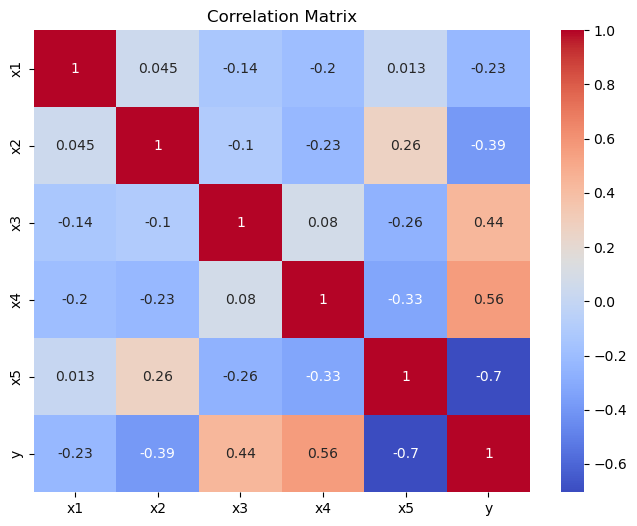

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a

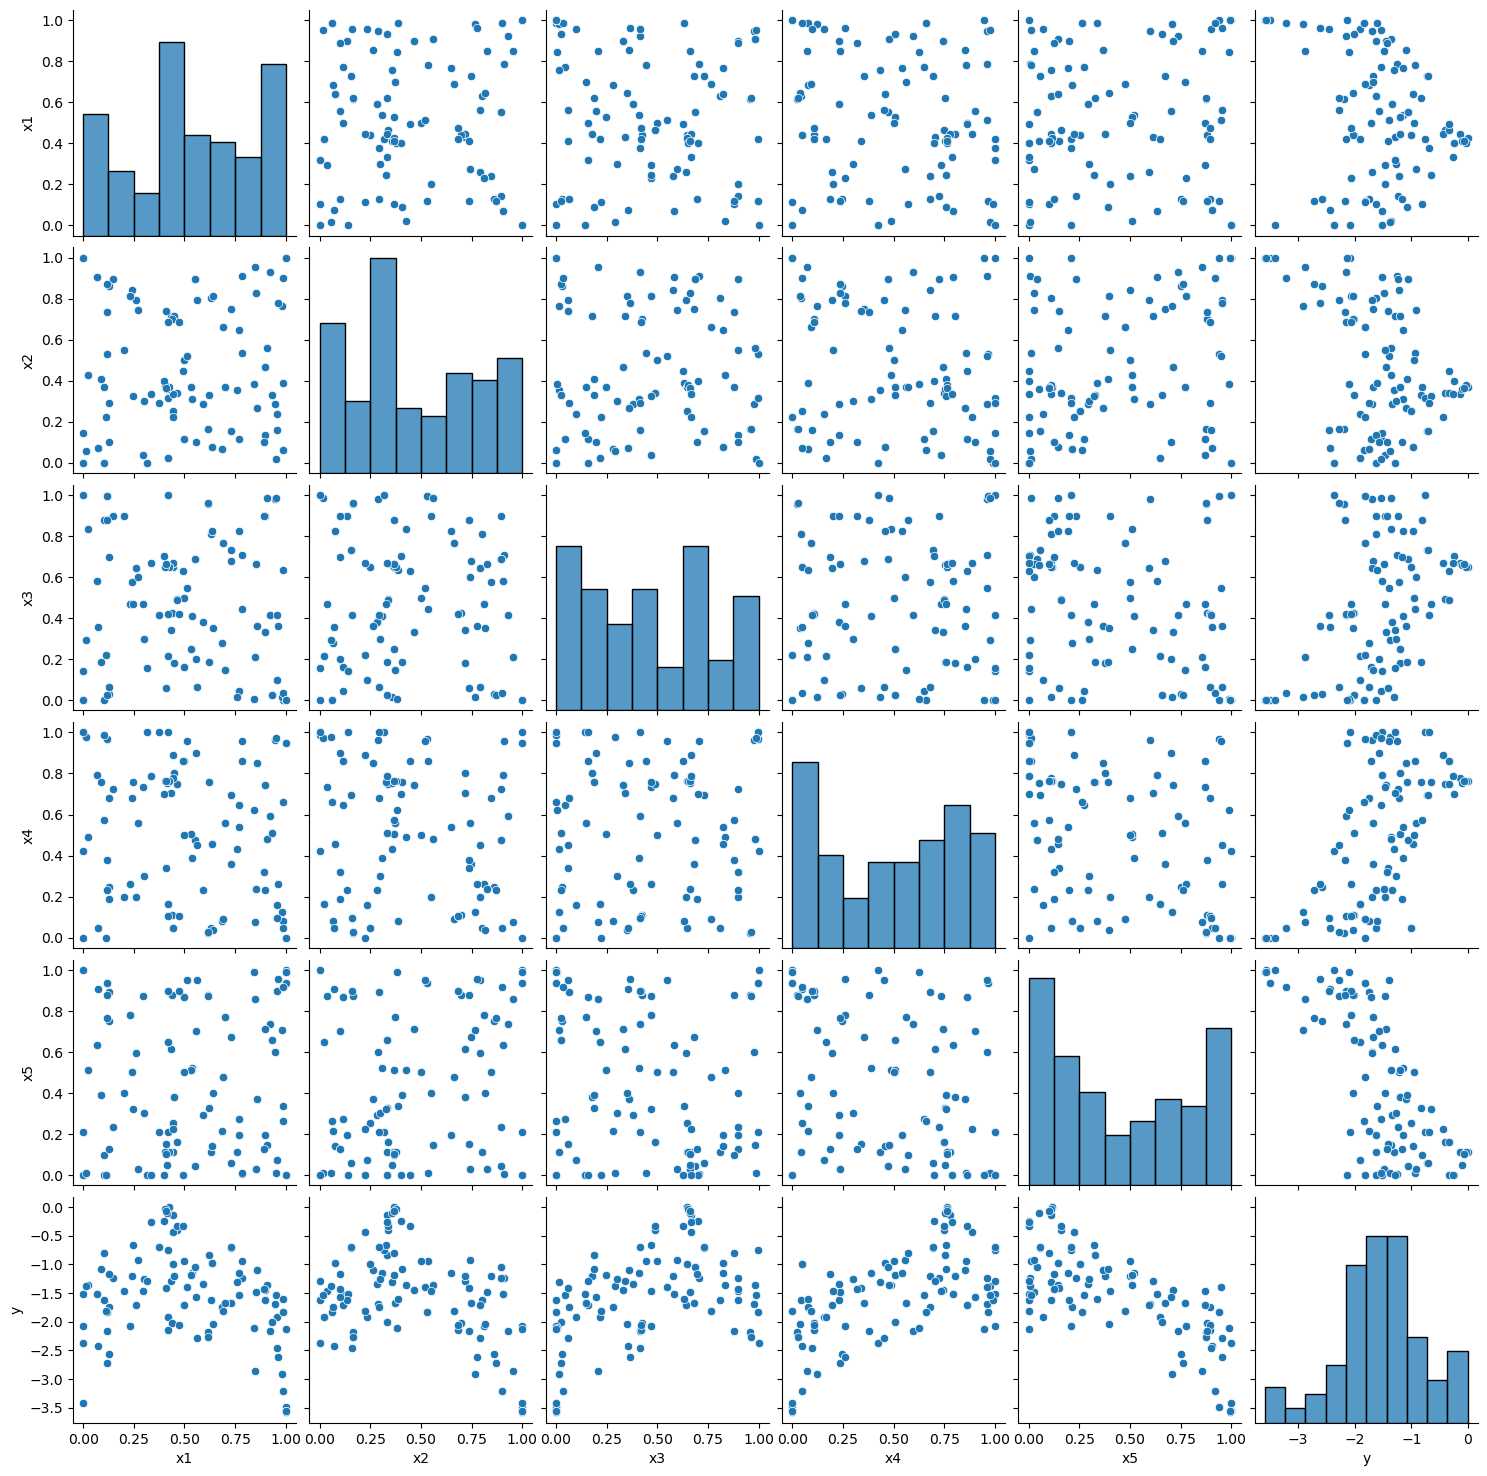

In [19]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

[Back to top](#Index:) 

<a id='part2'></a>

### Part 2 - Optimisation

In [20]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01
current_week_index=9

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)

print("Kappa Array:")
for index, value in enumerate(kappa_array):
    print(f"Week {index+1}(Index {index}): {value}")

print("Xi Array:")
for index, value in enumerate(xi_array):
    print(f"Week {index +1}(Index {index}): {value}")

Kappa Array:
Week 1(Index 0): 1.96
Week 2(Index 1): 1.764
Week 3(Index 2): 1.5876000000000001
Week 4(Index 3): 1.42884
Week 5(Index 4): 1.285956
Week 6(Index 5): 1.1573604000000002
Week 7(Index 6): 1.0416243600000001
Week 8(Index 7): 0.9374619240000002
Week 9(Index 8): 0.8437157316000001
Week 10(Index 9): 0.7593441584400001
Xi Array:
Week 1(Index 0): 0.1
Week 2(Index 1): 0.09000000000000001
Week 3(Index 2): 0.08100000000000002
Week 4(Index 3): 0.0729
Week 5(Index 4): 0.06561
Week 6(Index 5): 0.05904900000000001
Week 7(Index 6): 0.05314410000000001
Week 8(Index 7): 0.04782969000000001
Week 9(Index 8): 0.04304672100000001
Week 10(Index 9): 0.03874204890000001


In [21]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [22]:
def predict_in_batches(model, X, batch_size=10000, return_std=False):
    y_pred = []
    y_std = []
    for i in range(0, len(X), batch_size):
        if return_std:
            batch_pred, batch_std = model.predict(X[i:i + batch_size], return_std=True)
            y_std.extend(batch_std)
        else:
            batch_pred = model.predict(X[i:i + batch_size])
        y_pred.extend(batch_pred)
    return (np.array(y_pred), np.array(y_std)) if return_std else np.array(y_pred)

def expected_improvement(X_grid, gp, xi=0.01, model_type='sklearn'):
    mu, sigma = predict_in_batches(gp, X_grid, return_std=True) if model_type == 'sklearn' else gp.predict(X_grid)
    mu_sample_opt = np.max(mu)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def probability_of_improvement(X_grid, gp, xi=0.01, model_type='sklearn'):
    mu, sigma = predict_in_batches(gp, X_grid, return_std=True) if model_type == 'sklearn' else gp.predict(X_grid)
    mu_sample_opt = np.max(mu)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi

def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='sklearn'):
    mu, sigma = predict_in_batches(gp, X_grid, return_std=True) if model_type == 'sklearn' else gp.predict(X_grid)
    ucb = mu + kappa * sigma
    return ucb


In [23]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

def generate_nd_grid_hv(domain_bounds, num_points_per_dimension):
    """
    Generate an N-dimensional grid of points for optimization.

    Parameters:
    domain_bounds: A list of tuples, where each tuple contains the start and end values for one dimension.
    num_points_per_dimension: Number of points to generate in each dimension.

    Returns:
    X_grid: An N-dimensional numpy array of grid points.
    """
    
    # Create a list of arrays, each containing evenly spaced values for one dimension
    axis_values = [np.linspace(start, end, num_points_per_dimension) for start, end in domain_bounds]
    
    # Create the meshgrid for N dimensions and reshape it for model consumption
    X_grid_hv = np.array(np.meshgrid(*axis_values)).T.reshape(-1, len(domain_bounds))
    
    return X_grid_hv

# Example usage:
#domain_bounds = [(0.6, 0.65), (0.6, 0.65), (0.6, 0.65)]  # Let's say we have a 3D problem
#num_points_per_dimension = 100  # Number of points along each dimension
#X_grid = generate_nd_grid(domain_bounds, num_points_per_dimension)

In [24]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    #ei_series = pd.Series(ei_values.flatten())
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb



# Approach 2 : using RandomSearch with Gaussian

dict_keys(['k1', 'k2', 'k1__k1', 'k1__k2', 'k1__k1__constant_value', 'k1__k1__constant_value_bounds', 'k1__k2__length_scale', 'k1__k2__length_scale_bounds', 'k2__noise_level', 'k2__noise_level_bounds'])
Best Parameters: {'kernel__k1__k1__constant_value': 0.3905441275210792, 'kernel__k1__k2__length_scale': 0.005589524205217923, 'kernel__k2__noise_level': 0.1146210740342503}
Log-marginal-likelihood: -14.876885254500607
MSE: 0.003379668458991797
R-squared: 0.9941501148181126


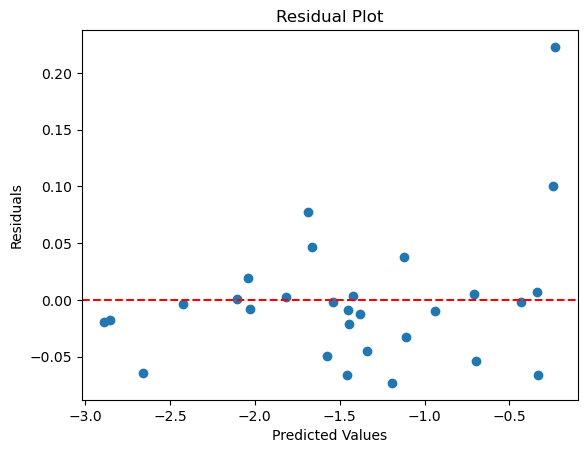

Current Timestamp:  2024-02-24 18:17:47.694682


In [23]:

#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.

# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min

param_distributions = {
    'kernel__k1__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k1__k2__length_scale': loguniform(1e-4, 1e2),
    'kernel__k2__noise_level': loguniform(1e-4, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e1))
# Print the parameter names
print(kernel.get_params().keys())

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer) 


random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')


print_timestamp()

# Approach 2 : Using BayesSearchCV with Gaussian

dict_keys(['k1', 'k2', 'k1__k1', 'k1__k2', 'k1__k1__constant_value', 'k1__k1__constant_value_bounds', 'k1__k2__length_scale', 'k1__k2__length_scale_bounds', 'k2__noise_level', 'k2__noise_level_bounds'])
Best Parameters: OrderedDict([('kernel__k1__k1__constant_value', 7.773697006110111), ('kernel__k1__k2__length_scale', 229.1257035436645), ('kernel__k2__noise_level', 2.6656355735562594)])
Log-marginal-likelihood: -1.6161596498846507
MSE: 0.010629232826510807
R-squared: 0.9850674329702108


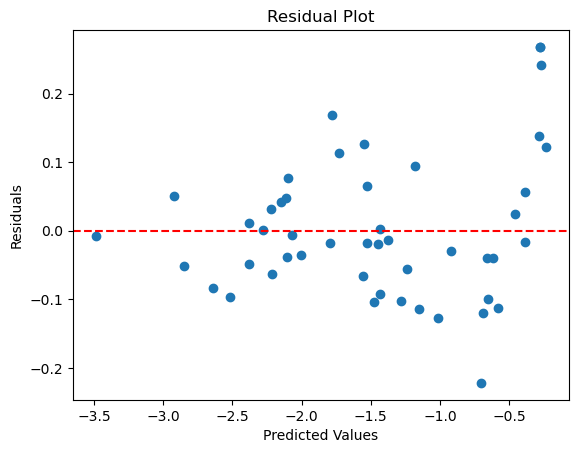

Current Timestamp:  2024-03-08 15:19:15.013615


In [25]:
# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min

param_distributions = {
    'kernel__k1__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k1__k2__length_scale': loguniform(1e-4, 1e2),
    'kernel__k2__noise_level': loguniform(1e-4, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e1))
# Print the parameter names
print(kernel.get_params().keys())

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer)

# Define the search space for the hyperparameters
search_spaces = {
    'kernel__k1__k1__constant_value': Real(1e-4, 1e5, prior='log-uniform'),
    'kernel__k1__k2__length_scale': Real(1e-5, 1e3, prior='log-uniform'),
    'kernel__k2__noise_level': Real(1e-10, 1e11, prior='log-uniform')
}

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(gp, search_spaces, n_iter=10, cv=10, random_state=42, n_jobs=-1)

# Fit the model
bayes_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')

print_timestamp()

# Approach 2 : Using GridSearch with Gaussian

dict_keys(['k1', 'k2', 'k1__k1', 'k1__k2', 'k1__k1__constant_value', 'k1__k1__constant_value_bounds', 'k1__k2__length_scale', 'k1__k2__length_scale_bounds', 'k2__noise_level', 'k2__noise_level_bounds'])
Best Parameters: {'kernel': 0.0316**2 * RationalQuadratic(alpha=0.215, length_scale=0.0464) + WhiteKernel(noise_level=0.0464)}
Log-marginal-likelihood: 69.54428436024622
MSE: 0.00031452733541728205
R-squared: 0.9996889323342038


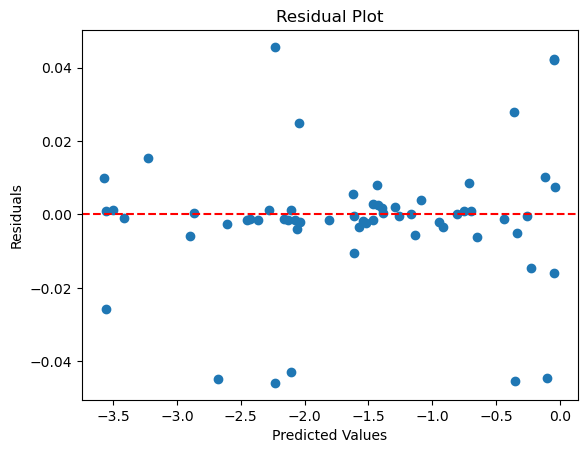

Current Timestamp:  2024-03-30 11:00:39.045303


In [25]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min


kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e1))
# Print the parameter names
print(kernel.get_params().keys())

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer)

# Define parameter grid with fixed values
param_grid = {
    'kernel': [
        C(constant_value) * RationalQuadratic(alpha=alpha, length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        for constant_value in np.logspace(-3, 7, num=7)  # Example range for constant_value
        for alpha in np.logspace(-2, 2, num=7)          # Example range for alpha
        for length_scale in np.logspace(-2, 2, num=7)   # Example range for length_scale
        for noise_level in np.logspace(-6, 1, num=7)    # Example fixed values for noise_level
    ]
}

grid_search = GridSearchCV(gp, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')

print_timestamp()

In [26]:
from joblib import dump

# Save the model to disk
dump(grid_search, 'f6_grid_search.joblib')

['f6_grid_search.joblib']

Best Parameters: {'kernel': 0.0316**2 * RationalQuadratic(alpha=0.0464, length_scale=1) + WhiteKernel(noise_level=0.0464)}
Log-marginal-likelihood: 3.2621853871196222
MSE: 0.0015169123697802499
R-squared: 0.9979998953963288


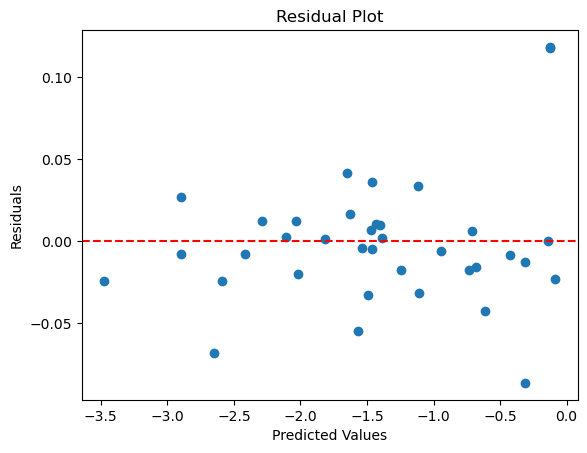

Current Timestamp:  2024-03-03 14:03:06.698141


In [24]:
from joblib import load

# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min

# Load the model from disk
grid_search = load('f6_grid_search.joblib')
best_gp = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")
mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')

print_timestamp()   

## Appoach 2: using sklearn GP model via random generated grid

In [27]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 5  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = current_week_index  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.382913-0.451287-0.702037-0.768396-0.184755
Next query PI:  0.379322-0.441917-0.677601-0.790776-0.149822
Next query UCB:  0.379322-0.441917-0.677601-0.790776-0.149822
Current Timestamp:  2024-03-30 12:16:58.146472


# Exploitation in high value region [0.999999, 0.998980, 0.000000, 0.000000, 0.991837, y=-3.58422268516109]

In [ ]:
domain_bounds= [(0.95, 1), (0.95, 1), (0, 0.05),(0, 0.05),(0.95,1)]
num_points_per_dimension = 60  # Number of points along each dimension
X_grid_hv = generate_nd_grid_hv(domain_bounds, num_points_per_dimension)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = current_week_index  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_grid_hv)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_grid_hv, columns=['x1', 'x2','x3','x4', 'x5'])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the smallest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=True)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F6 Grid Search Results Parallel Coordinates Plot")
print_timestamp()
 

Next query EI:  0.950000-0.950000-0.050000-0.050000-0.950000


In [28]:
def generate_sparse_grid(domain_bounds, points_per_dim):
    """Generate a sparse grid for high-dimensional spaces."""
    num_dims = len(domain_bounds)
    total_points = points_per_dim ** (1 / num_dims)
    axis_values = [np.linspace(start, end, int(np.ceil(total_points))) for start, end in domain_bounds]
    grid = np.meshgrid(*axis_values, indexing='ij')
    sparse_grid = np.vstack([x.ravel() for x in grid]).T
    return sparse_grid

# Example usage
#domain_bounds = [(0, 1), (0, 1), (0, 1)]  # 3D problem
#sparse_grid = generate_sparse_grid(domain_bounds, 1000)
#print("Sparse grid points:", sparse_grid.shape[0])


domain_bounds= [(0.95, 1), (0.95, 1), (0, 0.05),(0, 0.05),(0.95,1)]
num_points_per_dimension = 5000  # Number of points along each dimension
X_sparse_grid_hv = generate_sparse_grid(domain_bounds, num_points_per_dimension)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = current_week_index  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_sparse_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_sparse_grid_hv)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_sparse_grid_hv, columns=[f'x{i+1}' for i in range(len(domain_bounds))])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the smallest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=False)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F6 Sparse Search Results Parallel Coordinates Plot")
print_timestamp()

Next query EI:  0.950000-0.950000-0.050000-0.050000-0.950000
Next query PI:  0.950000-0.950000-0.050000-0.050000-0.950000
Next query UCB:  0.950000-0.950000-0.050000-0.050000-0.950000
        x1    x2    x3    x4    x5         y
210   0.95  0.95  0.05  0.05  0.95 -3.285192
1506  0.96  0.95  0.05  0.05  0.95 -3.294089
174   0.95  0.95  0.04  0.05  0.95 -3.296733
211   0.95  0.95  0.05  0.05  0.96 -3.296800
204   0.95  0.95  0.05  0.04  0.95 -3.296875
426   0.95  0.96  0.05  0.05  0.95 -3.300892
2802  0.97  0.95  0.05  0.05  0.95 -3.302840
1470  0.96  0.95  0.04  0.05  0.95 -3.305539
1507  0.96  0.95  0.05  0.05  0.96 -3.305652
1500  0.96  0.95  0.05  0.04  0.95 -3.305707
138   0.95  0.95  0.03  0.05  0.95 -3.308156
175   0.95  0.95  0.04  0.05  0.96 -3.308294
212   0.95  0.95  0.05  0.05  0.97 -3.308426
198   0.95  0.95  0.05  0.03  0.95 -3.308433
168   0.95  0.95  0.04  0.04  0.95 -3.308480
205   0.95  0.95  0.05  0.04  0.96 -3.308546
1722  0.96  0.96  0.05  0.05  0.95 -3.309766
4098  

               x1          x2          x3          x4          x5           y
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000
mean     0.964740    0.956800    0.039360    0.039760    0.960320   -3.344557
std      0.014757    0.008962    0.012308    0.011909    0.011941    0.014500
min      0.950000    0.950000    0.000000    0.000000    0.950000   -3.362285
25%      0.950000    0.950000    0.030000    0.030000    0.950000   -3.355731
50%      0.960000    0.950000    0.040000    0.040000    0.960000   -3.348410
75%      0.970000    0.960000    0.050000    0.050000    0.970000   -3.336866
max      1.000000    0.990000    0.050000    0.050000    1.000000   -3.285192
Current Timestamp:  2024-03-30 12:16:58.600492


In [102]:


def corner_search_space(domain_bounds, samples_per_dimension, corner_focus_ratio=0.1):
    """
    Generate a search space with more samples near the corners.

    :param domain_bounds: A list of tuples representing the bounds for each dimension (lower_bound, upper_bound).
    :param samples_per_dimension: The number of samples to take along each dimension.
    :param corner_focus_ratio: A float representing the ratio of the search space near the corners to be more densely sampled.
    :return: A numpy array representing the search space with more samples near corners.
    """
    # Adjust the loop logic based on your specific needs for handling dimensionality
    for _ in range(samples_per_dimension):
        point = []
        for lower_bound, upper_bound in domain_bounds:
            if np.random.rand() < corner_focus_ratio:
                # Sample closer to the bounds for corner-focused points
                if np.random.rand() > 0.5:
                    sample = np.random.uniform(lower_bound, lower_bound + (upper_bound - lower_bound) * corner_focus_ratio)
                else:
                    sample = np.random.uniform(upper_bound - (upper_bound - lower_bound) * corner_focus_ratio, upper_bound)
            else:
                # Sample anywhere within the bounds for other points
                sample = np.random.uniform(lower_bound, upper_bound)
            point.append(sample)
        yield point
        
        

# Example usage
#domain_bounds = [(0, 1), (0, 1), (0, 1)]  # 3D problem
#num_samples = 1000
#sobol_samples = sample_sobol_sequence(domain_bounds, num_samples)
#print("Sobol sequence samples:", sobol_samples.shape[0])

domain_bounds= [(0.999997, 1), (0.9989, 0.999), (0, 0.00001),(0, 0.00001),(0.991,0.99189)]
num_points_per_dimension = 3000  # Number of points along each dimension
corner_focus_ratio=0.09

# Use the generator to create a list of points
points_list = list(corner_search_space(domain_bounds, num_points_per_dimension, corner_focus_ratio))
# Convert the list of points to a NumPy array
X_corner_grid_hv = np.array(points_list)

# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = current_week_index  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_sobol_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_corner_grid_hv, batch_size=10000)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_corner_grid_hv, columns=[f'x{i+1}' for i in range(len(domain_bounds))])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the smallest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=False)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F6 Corner Search Results Parallel Coordinates Plot")
print_timestamp()

Next query EI:  0.952900-0.951473-0.049163-0.044238-0.990940
Next query PI:  0.952900-0.951473-0.049163-0.044238-0.990940
Next query UCB:  0.952900-0.951473-0.049163-0.044238-0.990940
            x1        x2            x3            x4        x5         y
521   0.999998  0.998983  6.207444e-07  8.711438e-06  0.991889 -3.584010
1191  0.999997  0.998981  3.462056e-06  9.194010e-06  0.991888 -3.584012
874   0.999999  0.998996  7.578123e-06  6.086887e-06  0.991886 -3.584014
2370  0.999999  0.998982  4.828405e-06  2.904894e-07  0.991887 -3.584015
93    0.999998  0.998985  9.500225e-06  4.257947e-06  0.991886 -3.584016
2820  0.999997  0.998990  9.265737e-06  1.494423e-07  0.991886 -3.584016
2214  0.999998  0.998987  7.268909e-07  3.354576e-06  0.991886 -3.584017
851   0.999998  0.998940  9.996122e-06  9.320814e-06  0.991889 -3.584019
1079  0.999999  0.998949  8.216398e-06  1.100054e-06  0.991888 -3.584020
1484  0.999999  0.998931  2.940522e-06  5.678157e-06  0.991889 -3.584021
1005  1.00000

                 x1          x2            x3            x4          x5  \
count  5.000000e+02  500.000000  5.000000e+02  5.000000e+02  500.000000   
mean   9.999985e-01    0.998952  5.151909e-06  4.965348e-06    0.991833   
std    8.992025e-07    0.000030  2.997929e-06  2.933235e-06    0.000034   
min    9.999970e-01    0.998900  9.163917e-10  1.481879e-08    0.991760   
25%    9.999977e-01    0.998926  2.780390e-06  2.606462e-06    0.991809   
50%    9.999985e-01    0.998952  5.201261e-06  4.887944e-06    0.991837   
75%    9.999993e-01    0.998980  7.638203e-06  7.544479e-06    0.991861   
max    1.000000e+00    0.999000  9.996122e-06  9.988951e-06    0.991889   

                y  
count  500.000000  
mean    -3.584143  
std      0.000077  
min     -3.584301  
25%     -3.584201  
50%     -3.584136  
75%     -3.584080  
max     -3.584010  
Current Timestamp:  2024-03-23 17:33:56.111804


In [29]:
from scipy.stats.qmc import Sobol

def sample_sobol_sequence(domain_bounds, num_samples):
    dim = len(domain_bounds)
    sobol_sampler = Sobol(d=dim, scramble=True)
    samples = sobol_sampler.random_base2(m=int(np.log2(num_samples)))
    # Rescale samples to the domain bounds
    rescaled_samples = np.array([start + (end - start) * samples[:, i] for i, (start, end) in enumerate(domain_bounds)]).T
    return rescaled_samples

# Example usage
#domain_bounds = [(0, 1), (0, 1), (0, 1)]  # 3D problem
#num_samples = 1000
#sobol_samples = sample_sobol_sequence(domain_bounds, num_samples)
#print("Sobol sequence samples:", sobol_samples.shape[0])

domain_bounds= [(0.95, 1), (0.95, 1), (0, 0.05),(0, 0.05),(0.95,1)]
num_points_per_dimension = 2048  # Number of points along each dimension
X_sobol_grid_hv = sample_sobol_sequence(domain_bounds, num_points_per_dimension)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = current_week_index  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_sobol_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_sobol_grid_hv, batch_size=10000)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_sobol_grid_hv, columns=[f'x{i+1}' for i in range(len(domain_bounds))])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the smallest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=False)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F6 Sobol Search Results Parallel Coordinates Plot")
print_timestamp()

Next query EI:  0.953922-0.957224-0.043470-0.049151-0.955977
Next query PI:  0.953922-0.957224-0.043470-0.049151-0.955977
Next query UCB:  0.953922-0.957224-0.043470-0.049151-0.955977
            x1        x2        x3        x4        x5         y
294   0.953922  0.957224  0.043470  0.049151  0.955977 -3.315530
1046  0.952780  0.951148  0.037666  0.046576  0.957809 -3.316745
1910  0.950504  0.954863  0.049738  0.024785  0.952215 -3.325437
178   0.969120  0.953580  0.044117  0.042343  0.954072 -3.328001
1576  0.977882  0.953095  0.044936  0.044618  0.953891 -3.330893
118   0.950710  0.963200  0.042950  0.043184  0.958233 -3.332411
802   0.972327  0.951316  0.035387  0.044047  0.952248 -3.332963
1326  0.958233  0.953193  0.021213  0.048092  0.950489 -3.333039
1678  0.956699  0.961335  0.047213  0.049775  0.967692 -3.333075
958   0.961014  0.955289  0.046864  0.045904  0.969521 -3.334358
1706  0.965465  0.955482  0.045752  0.036507  0.957914 -3.337231
1590  0.950998  0.950337  0.034497  

               x1          x2          x3          x4          x5           y
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000
mean     0.969279    0.963949    0.032669    0.033265    0.966832   -3.382192
std      0.013528    0.010844    0.012737    0.012597    0.012357    0.017447
min      0.950036    0.950013    0.000162    0.000072    0.950015   -3.404378
25%      0.957519    0.955146    0.024512    0.024742    0.956774   -3.397379
50%      0.967019    0.961677    0.035162    0.035976    0.964206   -3.384807
75%      0.979582    0.970375    0.043207    0.043755    0.975049   -3.371650
max      0.999843    0.999981    0.049981    0.049966    0.999513   -3.315530
Current Timestamp:  2024-03-30 12:16:58.928118


## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

In [30]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = current_week_index  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.868037-0.837135-0.193483-0.171492-0.820653
Next query PI:  0.868037-0.837135-0.193483-0.171492-0.820653
Next query UCB:  0.868037-0.837135-0.193483-0.171492-0.820653
Current Timestamp:  2024-03-30 12:17:47.496340


## Aproach 3:  a Sparse Gaussian Process model

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |               value  |  constraints  |  priors
  variance     |   13.42389491820339  |      +ve      |        
  lengthscale  |  2.5979788008502274  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.04037797  |      +ve      |        
MSE on validation set: 1.906254571580392
MSE: 0.028183078735265047
R-squared: 0.9721269233864797


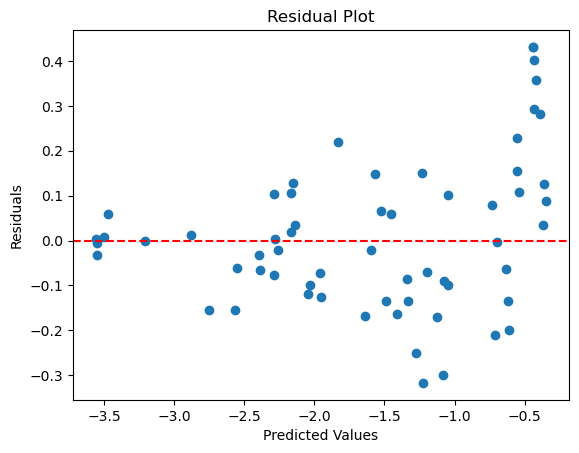

Current Timestamp:  2024-03-30 12:17:54.556096


In [31]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')

print_timestamp()

In [32]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

#mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.332297-0.404393-0.820234-0.968188-0.000781
Next query PI:  0.355274-0.427779-0.737276-0.942273-0.001618
Next query UCB:  0.355274-0.427779-0.737276-0.942273-0.001618
Current Timestamp:  2024-03-30 12:18:11.528623


[Back to top](#Index:) 

[Back to top](#Index:) 

<a id='part3'></a>

# Part 3 - Turbo Optimisation

In [33]:
from dataclasses import dataclass
import numpy as np
import torch
import math
from botorch.generation import MaxPosteriorSampling
from torch.quasirandom import SobolEngine
import botorch
import gpytorch

In [34]:
# we define a dataclass for our state
@dataclass
class TurboState:
    dim: int # dimension of the problem, aka input dimension
    batch_size: int = 1 # we could do batch optimization, but the capstone only does one query at a time
    length: float = 0.8 # the length of the current trust region
    length_min: float = 0.5 ** 7 # minimum length for the trust region
    length_max: float = 1.6 # maximum length for the trust region
    failure_counter: int = 0 # initialize counter of the number of failures to improve on the best observation
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0 # initialize counter of the number of success to improve on the best observation
    success_tolerance: int = 10  # Note: The original paper uses 3, this is the number of successes in a row needed to expand the region
    best_value: float =  float("inf") # best value so far, initialized to be the infimum. For maximisation, use -float("inf");For minimisation, keep float("inf") 
    restart_triggered: bool = False
    best_parameters: torch.Tensor = None  # Add this line to store the best parameters

    def __post_init__(self): # sets the failure tolerance based on the problem's dimension and batch size.
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size]) # number of failures needed in a row to shrink the trust region
        )


def update_state(state, Y_next, X_next):  # updates the TurboState based on new observations (Y_next). 
    #It checks if the new observation is a success or a failure and accordingly updates the success and failure counters. 
    #It also adjusts the trust region's length based on these counters.
    # count if a success, otherwise a failure

    # For the initial update or if a genuine improvement is found
    if state.best_value == float('inf') or min(Y_next) < state.best_value:
        state.best_value = min(state.best_value, min(Y_next).item())
        state.best_parameters = X_next[torch.argmin(Y_next)]
        print(f"Updated best value to {state.best_value} with new parameters.")
    else:
        state.success_counter = 0
        state.failure_counter += 1
        
    # check if we need to expand or shrink the trust region
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0
    # set the best value if we got a new observation
    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [35]:
def generate_batch(
    #generates the next query point in the optimization process using Thompson Sampling (TS). 
    #It requires a GP model and training data as inputs and operates within the current trust region.
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size = 1, # fix batch size to 1
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the trust region to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    
    # Check if weights is a scalar
    if weights.ndim == 0:
        # If weights is a scalar, handle it accordingly
        # For example, you might want to skip the operation or use a default value
        pass
    else:
        # Proceed with the original operation
        weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
        
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)
        
    # we focus only on thompson sampling as an acquisition function
    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),))] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        # set model to evaluation mode
        model.eval()
        posterior_distribution = model(X_cand)
        with torch.no_grad():  # We don't need gradients when using TS
            posterior_sample = posterior_distribution.sample()
            X_next_idx = torch.argmax(posterior_sample)
            X_next = X_cand[X_next_idx]

    return X_next

In [36]:
from sklearn.neighbors import NearestNeighbors

# Example: Setup a NearestNeighbors model for your dataset
# Assume X_data is your dataset features and Y_data are the targets
nn_model = NearestNeighbors(n_neighbors=1).fit(X_updated)

def simulate_evaluation(X_next, X_data, Y_data):
    
    # Assuming X_data and Y_data are your dataset features and targets
    nn_model = NearestNeighbors(n_neighbors=1).fit(X_data)
    
    # Convert X_next to numpy array if it's a tensor
    X_next_np = X_next.detach().cpu().numpy()  

    # Find the nearest neighbor in the dataset for X_next
    _, indices = nn_model.kneighbors(X_next_np.reshape(1, -1))  # Reshape for a single sample if necessary
    nearest_index = indices[0, 0]
    Y_next_simulated = Y_data[nearest_index]
    
    print(f"Simulated Y_next: {Y_next_simulated}")  # for debugging
    
    return torch.tensor([Y_next_simulated], dtype=torch.float32)  # Convert back to tensor

In [37]:
# we use the model given in the tutorial, we also add the hyper-parameter training as a method
class ExactGPModel(gpytorch.models.ExactGP): #  defines a Gaussian Process model with a constant mean and an RBF kernel. 
    #It's used in the optimization process to model the objective function.
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # set a constant mean
        self.mean_module = gpytorch.means.ConstantMean()
        # use a simple RBF kernel with constant scaling
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(0.1)))
        # set number of hyper-parameter training iterations
        self.training_iter = 200

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [38]:
# Initialize the TuRBO optimization with appropriate dimension
dim = X.shape[1]  # Dimension of your problem
turbo_state = TurboState(dim=dim)

if isinstance(X, torch.Tensor):
    X_train = X.clone().detach()
else:
    X_train = torch.tensor(X, dtype=torch.float32)

if isinstance(Y, torch.Tensor):
    y_train = Y.clone().detach()
else:
    y_train = torch.tensor(Y, dtype=torch.float32)


In [39]:
# Define Gaussian Process model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

#training the hyperparameters of the GP model with a likelihood function and an optimizer. 
#It also calculates the marginal log likelihood as a loss function.
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


for i in range(model.training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if i % 10 == 9:
        print(f'Iter %d/%d - Loss: %.3f   lengthscale: {model.covar_module.base_kernel.lengthscale.detach()}   noise: %.3f' % (
            i + 1, model.training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 10/200 - Loss: 0.626   lengthscale: tensor([[1.3007]])   noise: 0.340
Iter 20/200 - Loss: 0.320   lengthscale: tensor([[1.6687]])   noise: 0.139
Iter 30/200 - Loss: 0.022   lengthscale: tensor([[1.3453]])   noise: 0.057
Iter 40/200 - Loss: -0.219   lengthscale: tensor([[1.0244]])   noise: 0.023
Iter 50/200 - Loss: -0.347   lengthscale: tensor([[1.1053]])   noise: 0.010
Iter 60/200 - Loss: -0.391   lengthscale: tensor([[0.9414]])   noise: 0.006
Iter 70/200 - Loss: -0.434   lengthscale: tensor([[0.8141]])   noise: 0.004
Iter 80/200 - Loss: -0.523   lengthscale: tensor([[0.6547]])   noise: 0.003
Iter 90/200 - Loss: -0.639   lengthscale: tensor([[0.4810]])   noise: 0.002
Iter 100/200 - Loss: -0.744   lengthscale: tensor([[0.4575]])   noise: 0.001
Iter 110/200 - Loss: -0.847   lengthscale: tensor([[0.4888]])   noise: 0.000
Iter 120/200 - Loss: -0.932   lengthscale: tensor([[0.4671]])   noise: 0.000
Iter 130/200 - Loss: -0.988   lengthscale: tensor([[0.4619]])   noise: 0.000
Iter 140/20

In [40]:
def next_query_via_TurBO(train_x, train_y, turbo_state, training_iter, verbose=False):
    # Convert to tensors correctly to avoid warnings, assuming train_x and train_y are already tensors
    train_x = train_x.clone().detach().requires_grad_(True)  # Adjust based on your needs
    train_y = train_y.clone().detach().requires_grad_(True)  # Adjust based on your needs
    
    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = 1e-4  # Increase noise level
    model = ExactGPModel(train_x, train_y, likelihood)

    # Set model to training mode
    model.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # Marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        if verbose and i % 10 == 9:
            print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}   lengthscale: {model.covar_module.base_kernel.lengthscale}   noise: {model.likelihood.noise.item():.3f}')

    # Make predictions on the test set
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(train_x))
        predicted_means = predictions.mean
    
    # Correct conversion to numpy for MSE and R-squared calculations
    mse = mean_squared_error(train_y.detach().numpy(), predicted_means.detach().numpy())
    r_squared = r2_score(train_y.detach().numpy(), predicted_means.detach().numpy())
    print(f"MSE: {mse}")
    print(f"R-squared: {r_squared}")
    
    # After training loop
    final_mll = -loss.item()  # Since loss is the negative MLL
    print(f"Final Log-Marginal-Likelihood: {final_mll}")
    
    # Generate next batch of points
    X_next = generate_batch(turbo_state, model=model, X=train_x, Y=train_y)
    
    # Simulate evaluating the objective function at X_next using your dataset
    Y_next = simulate_evaluation(X_next, X_updated, Y_updated)  # Ensure X_data and Y_data are defined and accessible

    # Update turbo_state with the simulated Y_next and corresponding X_next
    # Note: Ensure the shapes of X_next and Y_next are compatible with your update_state function
    turbo_state = update_state(turbo_state, Y_next, X_next.unsqueeze(0))

    # After completing the optimization loop and other processing
    print(f'Best value: {turbo_state.best_value}')
    if turbo_state.best_parameters is not None:
     # Ensure tensor is detached from computation graph before conversion
        print(f'Best parameters: {turbo_state.best_parameters.detach().numpy()}')
    else:
        print("Best parameters not found.")
    
    return X_next
    
  #  print(f'Best value: {turbo_state.best_value}')
  #  if turbo_state.best_parameters is not None:
  #      print(f'Best parameters: {turbo_state.best_parameters.numpy()}')  # Assuming the parameters are in a tensor
    
    # Generate next batch of points
  #  return generate_batch(turbo_state, model=model, X=train_x, Y=train_y)

In [41]:
# Assuming X_new_points and Y_new_points are numpy arrays
new_data_X = np.copy(X_new_points)  # Use np.copy for numpy arrays
new_data_Y = np.copy(Y_new_points)

# If you need to use PyTorch tensors instead, you can convert them like this
new_data_X_tensor = torch.tensor(X_new_points).clone().detach()
new_data_Y_tensor = torch.tensor(Y_new_points).clone().detach()


next_query = next_query_via_TurBO(new_data_X_tensor, new_data_Y_tensor, turbo_state, training_iter=50, verbose=True)

# After calling next_query_via_TurBO and updating the turbo_state
print(f'Best value: {turbo_state.best_value}')

if turbo_state.best_parameters is not None:
    # Detach the tensor and convert to NumPy for printing
    print(f'Best parameters: {turbo_state.best_parameters.detach().numpy()}')
else:
    print("Best parameters not found.")

print(f'Next chose query: {format_query(next_query,6)}')

print_timestamp()
#mse, r2 = evaluate_model_performance(model, X_new_points, Y_new_points,'gpy')

Iter 10/50 - Loss: 0.849   lengthscale: tensor([[0.4681]], grad_fn=<AddBackward0>)   noise: 0.000
Iter 20/50 - Loss: 0.700   lengthscale: tensor([[0.3719]], grad_fn=<AddBackward0>)   noise: 0.000
Iter 30/50 - Loss: 0.704   lengthscale: tensor([[0.3434]], grad_fn=<AddBackward0>)   noise: 0.000
Iter 40/50 - Loss: 0.693   lengthscale: tensor([[0.3386]], grad_fn=<AddBackward0>)   noise: 0.000
Iter 50/50 - Loss: 0.660   lengthscale: tensor([[0.3429]], grad_fn=<AddBackward0>)   noise: 0.000
MSE: 1.2178948258812343
R-squared: -0.20449849031294676
Final Log-Marginal-Likelihood: -0.659883763573747
Simulated Y_next: -0.3367463122050448
Updated best value to -0.33674630522727966 with new parameters.
Best value: -0.33674630522727966
Best parameters: [0.42161247 0.61655709 0.53042308 0.89197468 0.16353286]
Best value: -0.33674630522727966
Best parameters: [0.42161247 0.61655709 0.53042308 0.89197468 0.16353286]
Next chose query: 0.421612-0.616557-0.530423-0.891975-0.163533
Current Timestamp:  2024-

[Back to top](#Index:) 

<a id='part4'> End</a>

In [45]:
# Replace the data with the provided data points
w11_predict = np.array([
    [0.437783, 0.38341 , 0.644599, 0.774895, 0.135404],
       [0.437783, 0.38341 , 0.644599, 0.774895, 0.135404],
       [0.805679, 0.872318, 0.085234, 0.193438, 0.877649],
       [0.825901, 0.915021, 0.107424, 0.16374 , 0.802007],
       [0.805679, 0.872318, 0.085234, 0.193438, 0.877649],
       [0.330195, 0.425656, 0.750463, 0.980827, 0.001246],
       [0.344323, 0.411287, 0.742625, 0.932526, 0.003323],
       [0.344323, 0.411287, 0.742625, 0.932526, 0.003323],
       [0.500495, 0.273099, 0.962102, 0.605763, 0.796991],
       [0.855981, 0.266165, 0.359416, 0.853218, 0.369172],
       [0.14551 , 0.678873, 0.929879, 0.919189, 0.049262],
       [0.951484, 0.958895, 0.031816, 0.04597 , 0.960746]
])

predictions = best_gp.predict(w11_predict) 

# Create a DataFrame to view the data points alongside their predictions
df_predictions = pd.DataFrame(w11_predict, columns=['x1', 'x2', 'x3','x4','x5'])
df_predictions['y'] = predictions

df_predictions_sorted = df_predictions.sort_values(by='y', ascending=True)

print(df_predictions_sorted)

          x1        x2        x3        x4        x5         y
11  0.951484  0.958895  0.031816  0.045970  0.960746 -3.310904
2   0.805679  0.872318  0.085234  0.193438  0.877649 -2.770653
4   0.805679  0.872318  0.085234  0.193438  0.877649 -2.770653
3   0.825901  0.915021  0.107424  0.163740  0.802007 -2.768841
8   0.500495  0.273099  0.962102  0.605763  0.796991 -1.607175
9   0.855981  0.266165  0.359416  0.853218  0.369172 -1.100995
10  0.145510  0.678873  0.929879  0.919189  0.049262 -1.039724
5   0.330195  0.425656  0.750463  0.980827  0.001246 -0.653925
6   0.344323  0.411287  0.742625  0.932526  0.003323 -0.562238
7   0.344323  0.411287  0.742625  0.932526  0.003323 -0.562238
0   0.437783  0.383410  0.644599  0.774895  0.135404 -0.068852
1   0.437783  0.383410  0.644599  0.774895  0.135404 -0.068852
